# Introduction

In this project, we build a linear model for predicting the number of rides per hour for a bike sharing system in Washington, DC. The data was obtained from the UCI Machine Learning Repository.


> Fanaee-T, H. (2013). Bike Sharing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5W894.

The data set contains an hourly count of rides between 12:00 am on 2011-01-01 and 11:59 pm on 2012-12-31. We use this data to create three models for predicting bike usage. For our first model, we engineer Fourier features to detect yearly, weekly, and daily seasonality in bike riding, and we perform least-squares regression on the resulting feature set. We then compare this model to a simple random forest and a third model built using `XGBoost`.

# Setup and import

The code below imports the packages we will use for this project along with the hourly ride data.

In [1]:
# import libraries and functions
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

#import data
top_dir = "https://raw.githubusercontent.com/mattjanko/"
filename = "bike-sharing/refs/heads/main/hour.csv"
data = pd.read_csv(top_dir + filename)
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [2]:
data.isna().sum().sum()

0

We see that the data includes 17379 rows and 17 columns. None of the rows contain NA values, which will simplify the data cleaning process.

The columns are clearly labeled. The UCI website also provides documentation explaining a few columns whose meanings are unclear:

* `holiday` is an indicator variable for holidays,
* `weekday` indicates the day of the week (with 0 represenenting Sunday),
* `workingday` is an indicator for days that are not holidays or weekends,
* `weathersit` is an ordinal variable representing the amount of precipitation,
* `atemp` is the "feel-like" temperature,
* `hum` is humidity,
* `casual` is the number of non-registered users renting bikes,
* `registered` is the number of registered users renting bikes, and
* `cnt` is the number of bike rides taken.

# Data cleaning

The target variable is `cnt`, the total number of rides per hour. A few facts stand out upon a preliminary inspection of the data. First, `cnt` is always the sum of `casual` and `registered`. This is because the latter two features record subcounts of non-registered and registered users of the bike sharing system. Including these features would introduce data leakage into the modeling process, so those features can be removed before proceeding further.

In [3]:
data = data.drop(["casual", "registered"], axis = 1)

Next, notice that `dteday` is partly redundant because it contains strings representing the same information contained in `yr` and `mnth`. The following code extracts from `dteday` a columns representing day of the year and then deletes `dteday`.

In [4]:
data["dteday"] = data["dteday"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)
data["day"] = data["dteday"].apply(
    lambda x: int(x.strftime("%d"))
)
data["dayofyr"] = data["dteday"].apply(
    lambda x: int(x.strftime("%-j"))
)
data = data.drop("dteday", axis = 1)

Finally, a handful of hours are missing from our data set. This is apparent because there are consecutive rows between which `instant` (an index variable) increases by 1 but `hr` increases by more than 1 modulo 24.

In [5]:
nc1 = data[data["instant"] - data["instant"].shift(1) != 1].shape[0]
nc2 = data[data["hr"] - data["hr"].shift(1) != 1].shape[0]
print(f"nonconsecutive entries in 'instant':{nc1 - 1}")
print(f"nonconsecutive entries in 'hr':{nc2 - 1}")

nonconsecutive entries in 'instant':0
nonconsecutive entries in 'hr':800


In an analysis of seasonality in `cnt`, the column `instant` would be more useful as a time dummy. The following code normalizes `instant` to represent time in years since 12:00 am on January 1, 2011.

In [6]:
data["instant"] = (data["yr"] == 1)*365*24 + (data["dayofyr"] - 1)*24 + data["hr"]
data["instant"] = data["instant"]/(365*24)

In [7]:
data.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,dayofyr
0,0.000000,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,1,1
1,0.000114,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,1,1
2,0.000228,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,1,1
3,0.000342,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,1,1
4,0.000457,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1,1


Before proceding with exploratory data analysis, we partition our dataset into training and test sets.

In [8]:
data_train, data_test = train_test_split(data, test_size = 0.2)

# Exploratory data analysis

Below is a heatmap of the correlation matrix of the dataset.

<Axes: >

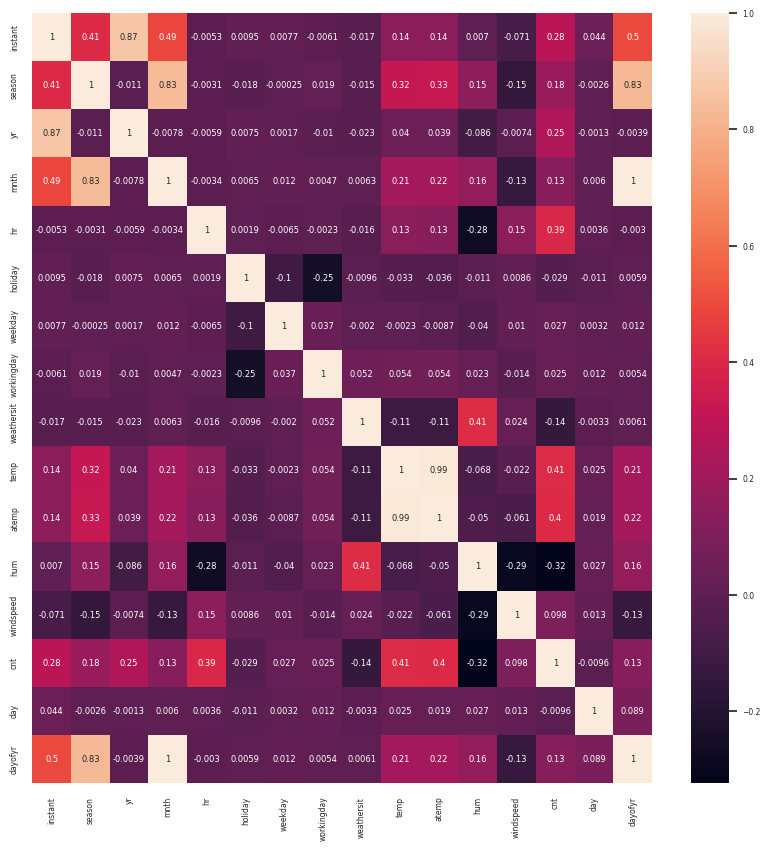

In [9]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set(font_scale = 0.5)
sns.heatmap(data_train.corr(), annot = True)

According to the correlation matrix, `cnt` is not very highly correlated with the time dummy `instant`. In a sense, this is surprising because one might expect that there would be a strong relationship between the number of rides in a given hour and the time or day, time or week, or time of year.

One explation for the lack of correlation is that the relationship between these variables is seasonal and nonlinear. Three plausible periods of seasonal variation are annual (due to changes in weather throughout the year), weekly (due to work schedules), and daily (due to sleep habits). The following plots show average values of `cnt` grouped by month, day of week, and hour of day, and they support our assumption that there is seasonality at the three frequencies we identified.

<Axes: xlabel='mnth'>

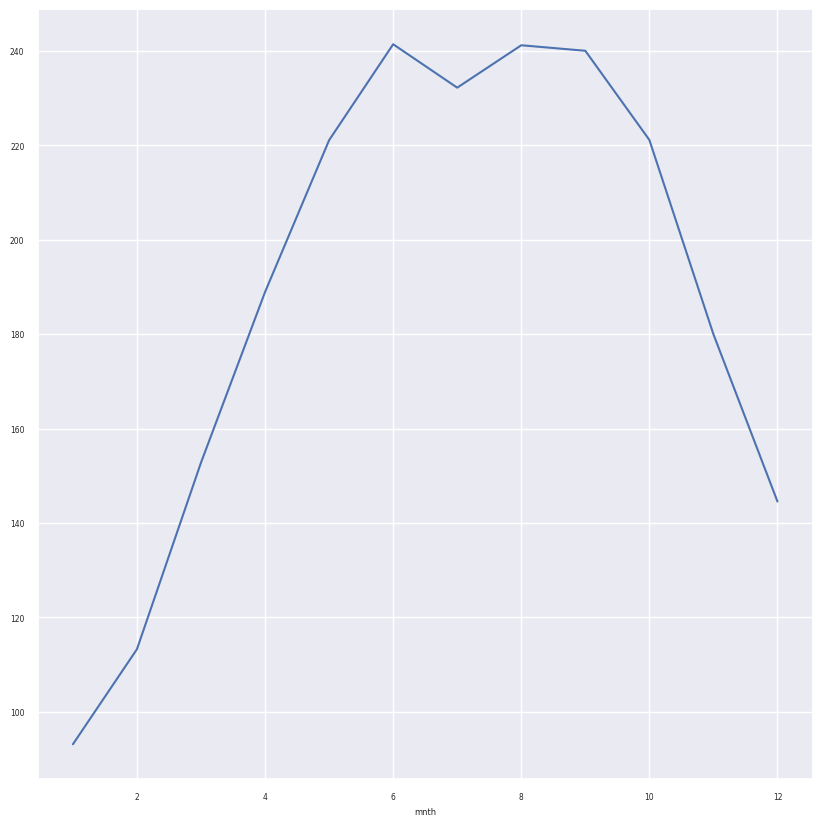

In [10]:
monthly_averages = data_train.groupby("mnth").mean()
monthly_averages["cnt"].plot()

<Axes: xlabel='weekday'>

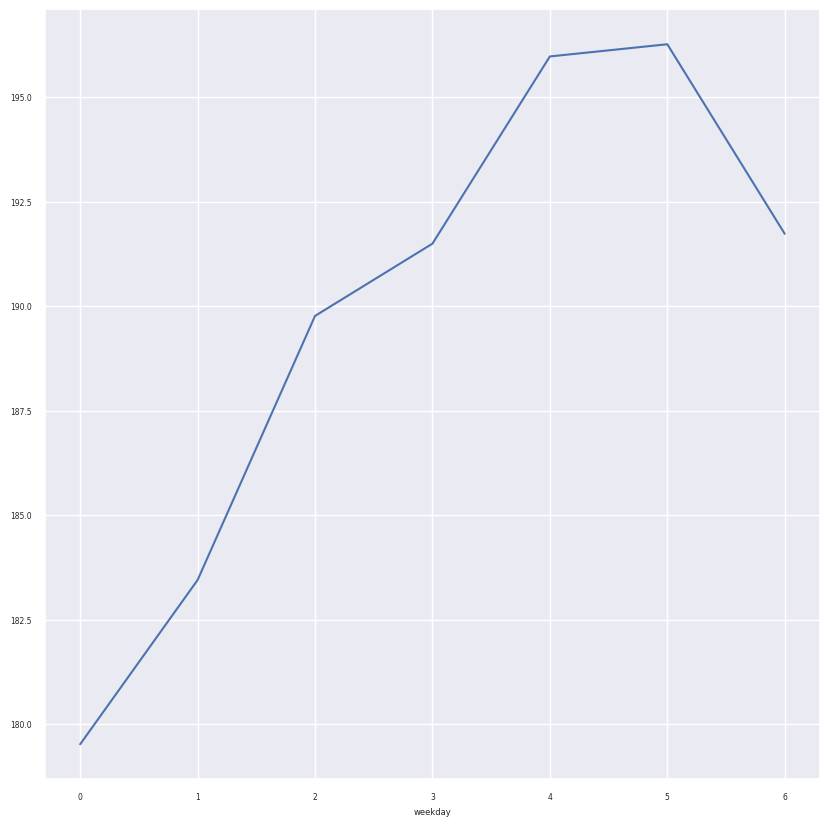

In [11]:
weekday_averages = data_train.groupby("weekday").mean()["cnt"]
weekday_averages.plot()

<Axes: xlabel='hr'>

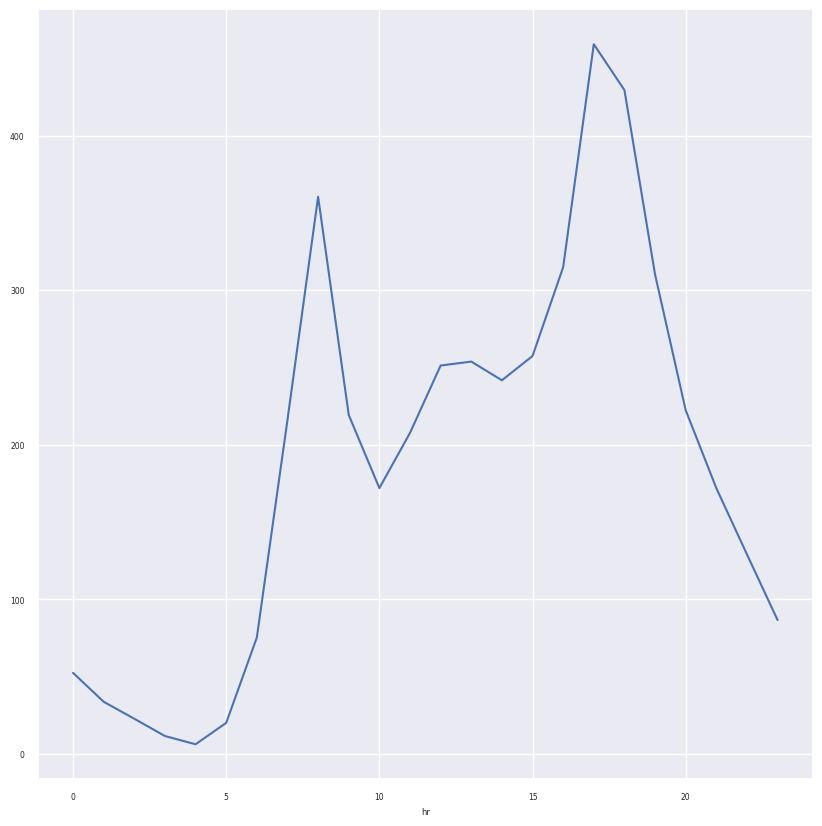

In [12]:
hourly_averages = data_train.groupby("hr").mean()["cnt"]
hourly_averages.plot()

To model seasonality with linear regression, we will introduce two pairs of Fourier features corresponding to two of the frequencies at which we see seasonal variation:

1. `np.sin(2*np.pi*instant)` and `np.cos(2*np.pi*instant)`, and
2. `np.sin(2*np.pi*365*instant)` and `np.cos(2*np.pi*365*instant)`.

These Fourier features can be used to approximate annual and daily seasonality. Since there are only 7 days per week (compared to 24 hours per day or 365 days per year), indicator variables are likely to give a better approximation of the weekly seasonality.

The plot showing average `cnt` values grouped by hour indicates has apparent spikes in bike sharing between 8 am and 9 am and again between 4 pm and 7 pm. These times correspond to common commute times to and from work, and we think that the spikes might be well-modeled by introducing an indicator variable `commute` for the hours correspoding to the spikes.

In [13]:
# add columns to training set
data_train["yrly1"] = np.sin(2*np.pi*data_train["instant"])
data_train["yrly2"] = np.cos(2*np.pi*data_train["instant"])
data_train["daily1"] = np.sin(2*np.pi*365*data_train["instant"])
data_train["daily2"] = np.cos(2*np.pi*365*data_train["instant"])
data_train["mo"] = data_train["weekday"] == 1
data_train["tu"] = data_train["weekday"] == 2
data_train["we"] = data_train["weekday"] == 3
data_train["th"] = data_train["weekday"] == 4
data_train["fr"] = data_train["weekday"] == 5
data_train["sa"] = data_train["weekday"] == 6
data_train["commute"] = data_train["hr"].isin([8,16,17,18])

# add columns to test set
data_test["yrly1"] = np.sin(2*np.pi*data_test["instant"])
data_test["yrly2"] = np.cos(2*np.pi*data_test["instant"])
data_test["mo"] = data_test["weekday"] == 1
data_test["tu"] = data_test["weekday"] == 2
data_test["we"] = data_test["weekday"] == 3
data_test["th"] = data_test["weekday"] == 4
data_test["fr"] = data_test["weekday"] == 5
data_test["sa"] = data_test["weekday"] == 6
data_test["daily1"] = np.sin(2*np.pi*365*data_test["instant"])
data_test["daily2"] = np.cos(2*np.pi*365*data_test["instant"])
data_test["commute"] = data_test["hr"].isin([8,16,17,18])

# Linear regression

We now proceed to model `cnt` using least squares regression. Our dataset now contains 26 features. However, now that we are using `instant` as a time dummy, the features `season`, `yr`, `mnth`, `day`, `hr`, `dayofyr`, `wkofyr`, and `weekday` are redundant. Also, `workingday` is redundant as long as we include `holiday` since `workingday` is simply an indicator for days that are not weekends or holidays, and this information is contained in the `weekday` and `instant` columns. Also, `temp` and `atemp` are highly correlated since `temp` records the tempearture and `atemp` records the feel-like tempertature, so only one of these two features needs to be included in the model. The other weather-related variables are `weathersit`, `hum`, and `windspeed`, and each of these seems to be plausibly related to the number of bike rides in a given hour. In total, we will incorporate 13 features in a least-squares regression model `ols_model_seas`:

 * `instant`,
 * `yrly1`,
 * `yrly2`,
 * `daily1`,
 * `dayly2`,
 * `mo`,
 * `tu`,
 * `we`,
 * `th`,
 * `fr`,
 * `sa`,
 * `commute`,
 * `holiday`,
 * `weathersit`,
 * `atemp`,
 * `hum`, and
 * `windspeed`.

In [14]:
ols_model = smf.ols(
    """
        cnt ~ instant + yrly1 + yrly2 + daily1 +
              daily2 + mo + tu + we + th + fr + sa +
              commute + holiday + weathersit +
              atemp + hum + windspeed
    """,
    data = data_train
).fit()
print(f"ols_model R-squared: {ols_model.rsquared}")
y_pred = ols_model.predict(data_test)
ols_mse = mean_squared_error(data_test["cnt"],y_pred)
print(f"ols_model mean squared prediction error: {ols_mse}")

ols_model R-squared: 0.5955503469270449
ols_model mean squared prediction error: 13426.133327177879


The $R^2$-value for `ols_model` is less than 0.6, so unsurprisingly, there is a rather high mean squared prediction error of about 13000. Still, this regression based on the engineered Fourier and `commute` features does better than a similar model based on the non-engineered features, which has a much lower $R^2$-value and gives predictions with a mean squared error of about 20000.

In [15]:
ols_model_non_eng = smf.ols(
    """
        cnt ~ yr + mnth + hr + holiday +
              weekday + workingday + weathersit +
              atemp + hum + windspeed
    """,
    data = data_train
).fit()
print(f"non-engineered R-squared: {ols_model_non_eng.rsquared}")
y_pred_non_eng = ols_model_non_eng.predict(data_test)
ols_non_eng_mse = mean_squared_error(data_test["cnt"], y_pred_non_eng)
print(f"non-engineered mean squared prediction error: {ols_non_eng_mse}")

non-engineered R-squared: 0.38586518213318444
non-engineered mean squared prediction error: 19972.23489672987


Though the feature-engineered least-squares model shows a substantial improvement in accuracy, an hourly mean squared error rate of 13000 corresponds to about 116 bike rides per hour, and this is a large value compared to the typical number of rides per hour represented in the dataset. This high error rate is likely due to nonlinear relationships between `cnt` and some of the features in `ols_model`. What we need is a model better able to represent these nonlinear relationshps.

# Ensemble models

The following two cells fit a random forest model and an `XGBoost` model to the test data using default hyperparameter values, compute predicted values given the test data, and return mean squared errors. We leave the Fourier features used in the linear regression out of the training data for the ensemble models. This is because these models might be able to detect the nonlinear relationship between `cnt` and `instant` that the Fourier features were meant to capture.

In [16]:
y_train = data_train["cnt"]
y_test = data_test["cnt"]
X_train = data_train.drop(
    ["yrly1", "yrly2", "daily1", "daily2", "cnt"],
    axis = 1
)
X_test = data_test.drop(
    ["yrly1", "yrly2", "daily1", "daily2", "cnt"],
    axis = 1
)
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
print(f"Untuned random forest mean square prediction error: {rf_mse}")

Untuned random forest mean square prediction error: 1561.9276102416572


In [17]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred)
print(f"Untuned XGBoost mean square prediction error: {xgb_mse}")

Untuned XGBoost mean square prediction error: 1436.271830033299


The hyperparameters of the random forest and `XGBoost` models are untuned, and even without the engineered Fourier features, these models improve upon the performance of linear regression by about an order of magnitude. To see what further improvements are possible in the random forest model using hyperparameter tuning, we perform a grid search. The `GridSearchCV` class initializes multiple instances of a predictor, each with different hyperparameter settings, and then uses a cross-validation to identify the hyperparameter settings that give the best performance.

In [18]:
rf_param_grid = {
    "max_depth": [i for i in range(1,10)] + [None],
    "max_features": ["sqrt", "log2", None]
}
rf_grid = GridSearchCV(
    RandomForestRegressor(),
    rf_param_grid
)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_params_
print(f"Best random forest hyperparameters: {best_rf}")

Best random forest hyperparameters: {'max_depth': None, 'max_features': None}


Interestingly, among the models tested in `rf_grid`, the random forest with `max_depth` and `max_features` set to `None` saw the best performance. This is the default setting for the `RandomForestRegressor` class, and it allows trees of arbitrary depth based on arbitrarily many features.

In [19]:
rf_model = RandomForestRegressor(
    max_depth = best_rf["max_depth"],
    max_features = best_rf["max_features"]
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
print(f"Tuned random forest mean square prediction error: {rf_mse}")

Tuned random forest mean square prediction error: 1551.9237488204835


We now use the same grid search method to look for improvements to the `XGBoost` model.

In [20]:
xgb_param_grid = {
    "max_depth": [i for i in range(1,10)] + [None],
    "learning_rate": [2**i for i in range(-5,1)] + [0.3]
}
xgb_grid = GridSearchCV(
    XGBRegressor(),
    xgb_param_grid
)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_params_
print(f"Best XGBoost hyperparameters: {best_xgb}")

Best XGBoost hyperparameters: {'learning_rate': 0.125, 'max_depth': 8}


In the case of `XGBoost`, best performance was obtained with a limited `max_depth` and a learning rate a bit lower than the default of 0.3.

In [21]:
xgb_model = XGBRegressor(
    learning_rate = best_xgb["learning_rate"],
    max_depth = best_xgb["max_depth"]
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred)
print(f"Tuned XGBoost mean squared prediction error: {xgb_mse}")

Tuned XGBoost mean squared prediction error: 1305.5510459476327


# Results

In terms of prediction accuracy, the best model was `XGBoost`. The plot bellow shows the distribution of prediction errors. The plot is centered at approximately 0, indicating that `XGBoost` is giving approximately unbiased predictions. The square root of the mean squared prediction error is about 35, and approximately 80% of the data lie within 35 units of 0. Also, the error distribution seems to be independent of `instant`, so the model is performing consistently on data over the two-year interval covered by the training set. In a bike sharing system than regularly sees several hundred rides per hour, predicting the number of rides in a given hour to within about 35 rides 80% of the time seems like a good result given a relatively simple model.

Mean prediction error: -0.5914205879281662


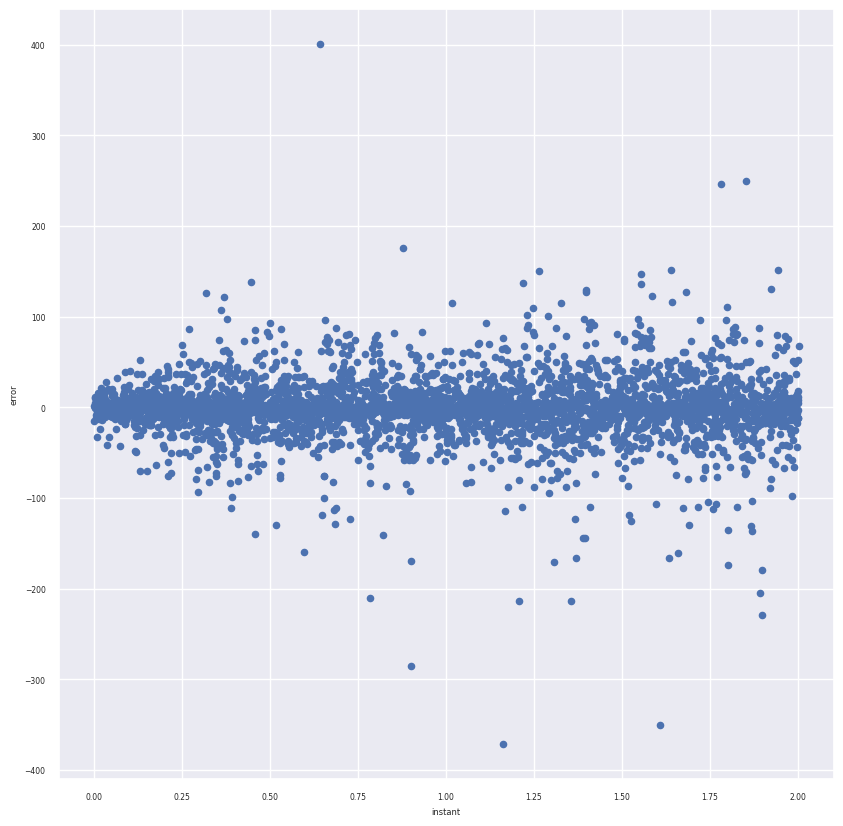

In [22]:
best_result = pd.DataFrame(X_test.copy())
best_result["pred_cnt"] = y_pred
best_result["act_cnt"] = y_test
best_result["error"] = y_test - y_pred
best_result.plot(kind = "scatter", x = "instant", y = "error")
print(f"Mean prediction error: {best_result['error'].mean()}")

In [23]:
best_result[abs(best_result["error"]) > 35].sort_values("error")

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,mo,tu,we,th,fr,sa,commute,pred_cnt,act_cnt,error
10062,1.162557,1,1,2,8,0,3,1,2,0.28,...,False,False,True,False,False,False,True,487.435303,116,-371.435303
13971,1.609132,3,1,8,8,0,5,1,3,0.62,...,False,False,False,False,True,False,True,469.282928,119,-350.282928
7769,0.899543,4,0,11,8,0,5,1,1,0.26,...,False,False,False,False,True,False,True,359.256500,74,-285.256500
16453,1.896689,4,1,11,7,0,5,1,1,0.24,...,False,False,False,False,True,False,False,305.723755,77,-228.723755
10453,1.207306,1,1,3,16,0,5,1,3,0.48,...,False,False,False,False,True,False,True,342.340271,129,-213.340271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16870,1.944406,4,1,12,17,0,1,1,2,0.48,...,True,False,False,False,False,False,True,464.617584,616,151.382416
7577,0.877626,4,0,11,8,0,4,1,3,0.34,...,False,False,False,True,False,False,True,179.063629,355,175.936371
15470,1.780251,4,1,10,19,0,4,1,1,0.44,...,False,False,False,True,False,False,False,496.660187,743,246.339813
16063,1.852055,4,1,11,0,0,3,1,2,0.30,...,False,False,True,False,False,False,False,32.852161,283,250.147839


# Discussion

Linear regression is a low-flexibility approach because its effectiveness relies heavily on the nature of the relationship between the response variable and the features included in the model. When regression is performed on features that have linear relationships with the target variable, then the resulting model will not tend to give accurate predictions. In this situation, transformations of those features might result in linear relationships (e.g., the Fourier features we introduced), and regression on the transformed features might be able to give more accurate predictions. However, this process can take careful engineering that is highly dependent on the context of the modeling task.

In contrast, random forests and related models like `XGBoost` offer a more flexible approach in the sense that these ensemble methods make very few assumptions about the structure of the data under consideration. In principle, each decision tree in a random forest or `XGBoost` model can be constructed to fit training data perfectly. Likewise, when multiple decision trees are combined in a single random forest, the fit between the resulting model and the training data can be arbirarily close, and this closeness of fit is achievable without any data preprocessing or feature engineering that is often necessary in successful applications of linear regression.

Due to the difference in flexibility, one would expect to see a tendency toward higher bias and lower variance in linear regression models and toward lower bias and higher variance in models based on random forests. This tradeoff turns out to be observable in the models we have built for this project. The following cell removes a holdout row from the original data set and proceeds to fit `ols_model` and `xgb_model` on 100 different training splits. Predictions for `cnt` in the holdout row are made based on each fitting of the models, and summary statistics for the predictions are shown.

In [24]:
# create seasonal features for entire data set
data["yrly1"] = np.sin(2*np.pi*data["instant"])
data["yrly2"] = np.cos(2*np.pi*data["instant"])
data["daily1"] = np.sin(2*np.pi*365*data["instant"])
data["daily2"] = np.cos(2*np.pi*365*data["instant"])
data["mo"] = data["weekday"] == 1
data["tu"] = data["weekday"] == 2
data["we"] = data["weekday"] == 3
data["th"] = data["weekday"] == 4
data["fr"] = data["weekday"] == 5
data["sa"] = data["weekday"] == 6
data["commute"] = data["hr"].isin([8,16,17,18])

# hold out one row of data
data, holdout = train_test_split(data, test_size = 1)
# prepare training data for xgb
holdout_xgb = holdout.drop(
    ["yrly1", "daily2", "daily1", "cnt", "yrly2"],
    axis = 1
)

# initialize lists to store predictions
ols_predictions = []
xgb_predictions = []

# fit models on 100 training splits
for i in range(100):
    # split off a training set
    data_train, _ = train_test_split(data, test_size = 0.2)

    # generate a prediction for the holdout row using ols_model
    ols_model = smf.ols(
        """
            cnt ~ instant + yrly1 + yrly2 + daily1 +
                  daily2 + mo + tu + we + th + fr + sa +
                  commute + holiday + weathersit +
                  atemp + hum + windspeed
        """,
        data = data_train
    ).fit()
    ols_pred = ols_model.predict(holdout)

    # prepare training data for XGBoost
    y_train = data_train["cnt"]
    X_train = data_train.drop(
        ["yrly1", "yrly2", "daily1", "daily2", "cnt"],
        axis = 1
    )

    # generate a prediction for the holdout row using xgb_model
    xgb_model = XGBRegressor(
        learning_rate = best_xgb["learning_rate"],
        max_depth = best_xgb["max_depth"]
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(holdout_xgb)

    # record predcitions
    ols_predictions.append(ols_pred.iloc[0])
    xgb_predictions.append(xgb_pred[0])

# compute summary statistics
act_cnt = holdout['cnt'].iloc[0]
ols_mean = np.mean(ols_predictions)
xgb_mean = np.mean(xgb_predictions)
ols_var = np.var(ols_predictions)
xgb_var = np.var(xgb_predictions)
print(f"Actual cnt value for holdout: {holdout['cnt'].iloc[0]}")
print(f"Mean prediction error for ols_model: {act_cnt - ols_mean}")
print(f"Mean prediction error for xgb_model: {act_cnt - xgb_mean}")
print(f"Prediction variance for ols_model: {ols_var}")
print(f"Prediction variance for xgb_model: {xgb_var}")

Actual cnt value for holdout: 143
Mean prediction error for ols_model: -103.79555320626088
Mean prediction error for xgb_model: -11.193450927734375
Prediction variance for ols_model: 2.4329646376328413
Prediction variance for xgb_model: 17.744298934936523


As expected, the mean prediction error on the holdout row for `ols_model` was significantly higher in absolute value than the mean prediction error for `xgb_model`, but `ols_model` had lower variance among its predictions compared to `xbg_model`. In other words, `ols_model` was less accurate but more consistent than `xgb_model`.

Accuracy and consistency are both characteristics of useful models, corresponding to low bias and low variance. For the `XGBoost` model, many predictions tend to be accurate on average, but any single prediction is relatively sensitive to the training data used to fit the model. For linear regression, predictions are not particularly accurate on average, although any single prediction is unlikely to change much in response to resampling the training data. To compare the two sides of this tradeoff between bias and variance, one can consider the mean squared prediction error on a large test set. In this case, `xgb_model` had a mean squared prediction error about one order of magnitude lower than `ols_model`. This indicates that, even though any single prediction by `xgb_model` is not very reliable, the low bias observed in `xgb_model` more than makes up for its high variance when compared to `ols_model`. Therefore, `XGBoost` gave the best performing model in this project.

Further improvements are likely possible. Besides the commute and weekday indicators, we used none of the engineered features in training the ensemble models that we used for the linear regression model. We did this because, in principle, ensemble models are capable of detecting nonlinear relationships. Even so, incorporating Fourier features or other engineered features into random forests or `XGBoost` models might lead to better performance. Likewise, exploring nonlinear relationsihps among the non-temporal features and from them engineering new features with linear relationships to `cnt` might, in principle, improve the performance of linear regression. These would be interesting avenues to pursue with further research.